In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
os.chdir('/home/seidi/Repositories/mestrado_final/')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

import utils
# Reading data
mb = utils.read_mb()
mb = utils.read_int_mb()
mb = mb[mb.k_searching == 30]
mf = utils.read_mf()

## Preparing data

In [ ]:
recs = pd.read_csv('src/notebooks/overview/recommendations/final_recs_k=30.csv')

datasets = {
    'texture': 'Texture',
    'moments': 'Moments',
    'colorHisto': 'Histogram',
    'sift': 'SIFT',
    'mnist': 'MNIST',
    'mnist121d': 'MNIST121d',
    'fashion': 'Fashion-MNIST',
    'cophir282': 'Cophir282',
    'cophir64': 'Cophir64',
    'base71': 'Synthetic', 
    # 'base74': 'Syn74', 
    # 'base68': 'Syn68',
    # 'base72': 'Syn72',
    # 'base70': 'Syn70',
}
recs.Dataset = recs.Dataset.map(lambda x: datasets.get(x, x))

approaches = {
    'gmm': 'GMM',
    'gmm+': 'GMM+',
    'tmmgs': 'TMM-GS',
    'tmmgs+': 'TMM-GS+',
    'tmms': 'TMM-S',
    'tmms+': 'TMM-S+',  
    'Light': 'Loose',
    'Heavy': 'Tight'  
}
recs.approach = recs.approach.map(lambda x: approaches.get(x, x))

graph_type = {
    0: 'NSW',
    1: 'NNDescent',
    2: 'Brute-kNNG',  
}
recs.graph_type = recs.graph_type.map(lambda x: graph_type.get(x, x))

recs = recs.rename(columns={
    'approach': 'Approach',
    'graph_type': 'Graph Algorithm'
})

data_order = ['Moments', 'Histogram', 'Texture', 'MNIST121d', 'MNIST', 'Fashion-MNIST', 'SIFT', 'Cophir282', 'Cophir64', 'Synthetic']#, 'Syn74', 'Syn68', 'Syn72', 'Syn70']
recs.set_index('Dataset', inplace=True)
recs = recs.loc[data_order, :].reset_index()
recs.head()

In [ ]:
from itertools import product
path = 'src/notebooks/infoSys/figures/recommendations'

RECOMMENDATIONS_TYPES = {
    'quick': ['Optimal', 'GMM', 'GMM+', 'Tight', 'Loose'], 
    'tuned': ['Optimal', 'GridSearch', 'TMM-GS', 'TMM-GS+', 'TMM-S', 'TMM-S+']
}
OPTIMIZING_VALUES = {
    'qt': 'Query Time (ms)', 
    'nn': 'NN', 
    'dt': 'Distance Computations'
}
REQUIRED_RECALLS = [[0.95], [0.9, 0.99]]

In [ ]:
prods = product(RECOMMENDATIONS_TYPES.keys(), OPTIMIZING_VALUES.keys(), REQUIRED_RECALLS)
for rec_type, opt, req_recall in prods:
    final_recommendations = recs[recs.Approach.isin(RECOMMENDATIONS_TYPES[rec_type])].copy()

    fig, axes = plt.subplots(len(req_recall), 1, figsize=(10, 6), dpi=300, sharex=True)
    axes = axes.reshape(-1) if isinstance(axes, np.ndarray) else [axes]
    for ax, recall in zip(axes, req_recall):
        df = final_recommendations[(final_recommendations.optmizing == opt) & (final_recommendations.required_recall == recall)].copy()
        g = sns.barplot(x='Dataset', y=OPTIMIZING_VALUES[opt], hue='Approach', hue_order=RECOMMENDATIONS_TYPES[rec_type], data=df, ax=ax)
        test = df.copy()
        test.set_index('Approach', inplace=True)
        drop = list(set(RECOMMENDATIONS_TYPES[rec_type]) - set(test.index.unique()))
        o = [h for h in RECOMMENDATIONS_TYPES[rec_type] if h not in drop]
        test = test.loc[o, :].reset_index()
        for ix, p in enumerate(g.patches):
            if ix == len(test):
                break
            tmp = test.loc[ix, :]
            if tmp.Dataset != 'Dataset' and tmp.Recall < tmp.required_recall:
                g.annotate(
                    # format(p.get_height(), '.1f'),
                    tmp.Recall,
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9),
                    size=10,
                    rotation=60,
                    textcoords = 'offset points'
                    ) 
        if OPTIMIZING_VALUES[opt] != 'NN':
            ax.set_yscale('log')
        # if recall != 0.95:
        #     ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title(fr'Required recall$\geq{recall}$') # 
        ax.get_legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=5)
    plt.subplots_adjust(hspace=0.3)
    # plt.suptitle(OPTIMIZING_VALUES[opt])
    recalls = ','.join(map(str, req_recall))
    plt.savefig(f'{path}/{rec_type}_{opt}_{recalls}.png', bbox_inches = 'tight', pad_inches = 0, dpi=300)

In [ ]:
path = '/home/seidi/Repositories/Mestrado_quali/figures/journal'

base = 'sift_999900'
graph_type = 0
k = 30

rr_original = [1, 5, 10, 20, 40, 80, 120, 240]
nn_original = [5, 25, 55, 100]

plt_cfg = {
    'x': 'R values',
    'y': 'Recall',
    'marker': 'o',
    'markersize': 8
}

fig, axes = plt.subplots(4, 2, figsize=(10,8), sharey=True, sharex=True, dpi=100)
axes = iter(axes.reshape(-1))
plt.subplots_adjust(wspace=0.05)

for NN in nn_original:
    tmp = mb[
        (mb.IndexParams == NN) &
        (mb.graph_type == 0) &
        (mb.index == base)
    ].copy()
    tmp = tmp.rename(columns={'QueryTimeParams': 'R values'})
    ax = next(axes)
    ax.set_title(f'NN={NN} and original R values')
    sns.lineplot(data=tmp[tmp['R values'].isin(rr_original)], ax=ax, **plt_cfg)

    tmp = mb[
        (mb.IndexParams == NN) &
        (mb.graph_type == 0) &
        (mb.index == base)
    ].copy()
    tmp = tmp.rename(columns={'QueryTimeParams': 'R values'})
    ax = next(axes)
    ax.set_title(f'NN={NN} and interpolated R values')
    sns.lineplot(data=tmp, ax=ax, **plt_cfg)

    NN += 10

plt.subplots_adjust(hspace=.3)
plt.savefig(f'{path}/interpolation.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=300)

In [ ]:
os.path.join(path, p)

In [ ]:
path = '/home/seidi/Repositories/prox_graph_auto_config/src/notebooks/2020.11.03/results/scores'
res = pd.DataFrame()
for p in os.listdir(path):
    df = pd.read_csv(os.path.join(path, p))
    df.base = df.base.apply(lambda x: x.split('_')[0])
    if 'mse' in df.columns:
        df.mse = df.mse ** (1/2)
        df = df.rename(columns={'mse': 'rmse'})

    df = df[['base', 'target', 'r2', 'rmse']]
    df['method'] = p.split('.')[0]
    res = pd.concat([res, df])

res.reset_index(inplace=True, drop=True)
res.method = res.method.map({
    'similarity_common_params': 'sim_cp',
    'similarity_interpolations': 'sim_int',
    'similarity': 'sim',
    'gmm_scores_interpolated_v4': 'gmm_v2',
    'similarity_interpolations_v2': 'sim_int_v2',
    'weighted_similarity': 'sim_weighted',
    'k=1': 'k=1',
    'gmm_scores_original':          'a1',
    'gmm_scores_interpolated_v3':   'a2',
    'gmm_scores_interpolated_v2':   'a3',
    'gmm_scores_interpolated_v1':   'a4',
    })

PALETTE = {
    "sim": "darkblue",
    "sim_cp": "lightsteelblue",
    "sim_int": "aqua",
    "gmm_v2": "yellow",
    "sim_int_v2": "pink",
    'sim_weighted': 'black',
    'k=1': 'blue',
    "v1": "green",
    "v2": "orange",
    "v3": "tomato",
    "v4": "red",
}

HUE_ORDER = ['a1', 'a2', 'a3', 'a4']
res[(res.target=='Recall') & (res.method=='a1')]

fig, ax = plt.subplots(1,1, figsize=(10, 4), dpi=300)
target = 'Recall'
tmp = res[(res.method.isin(HUE_ORDER)) & (res.target == target)].copy()

tmp = tmp.set_index('method').loc[HUE_ORDER].reset_index()
sns.boxplot(x='method', y='r2', data=tmp, color='gray')
ax.set_title('Overall performance for recall prediction')
ax.set_ylabel(r'$r^2$ score')
ax.set_xlabel('Approach')
ax.set_ylim(0, 1.1)
plt.savefig('/home/seidi/Repositories/Mestrado_quali/figures/journal/interpolation_validation.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=300)

In [ ]:
nn = 5
r = 5
k = 30
graph_type = 0
tmp = mb[
    (mb.nr_inst.isin(np.log([999900, 67940, 69900, 500000]))) &
    # (mb.IndexParams == nn) & 
    # (mb.k_searching == k) &
    (~mb.index.str.startswith('base')) &
    (mb.graph_type == graph_type) 
    ].copy()

tmp = tmp.rename(columns={'lid_mean': 'ID', 'rv': 'RV', 'QueryTimeParams': 'R values', 'IndexParams': 'NN values'})

hue = ['ID', 'RV']
x_axis = ['R values', 'NN values']
from itertools import product
prods = product(hue, x_axis)

fig, ax = plt.subplots(2,2,figsize=(12,5), dpi=300, sharex='col')
axes = iter(ax.reshape(-1))

for h, x in prods:
    ax = next(axes)
    if x.startswith('NN'):
        sns.lineplot(x=x, y='Recall', hue=h, data=tmp[tmp['R values'] == r], marker='o', ax=ax)
    else:
        sns.lineplot(x=x, y='Recall', hue=h, data=tmp[tmp['NN values'] == nn], marker='o', ax=ax)
    ax.legend(title=h, ncol=3)
    

# sns.lineplot(x='R values', y='Recall', hue='RV', data=tmp, marker='o', ax=ax[1])

plt.suptitle(f'Fixed params: k={k}, graph=NSW', fontsize=18)
# ax[0].set_title('Intrinsic Dimensionality')
# ax[1].set_title('Relative Variance')

# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=3)
plt.subplots_adjust(hspace=0.1)

print('All real datastes plus one sift subset (500k)')
plt.savefig('/home/seidi/Repositories/Mestrado_quali/figures/journal/complexity_metafeatures.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=300)

In [ ]:
all_scores = pd.read_csv('src/notebooks/overview/results/old_new_evaluation.csv')
approaches = {
    'old_mfs+old_bases': 'MF_V1 + MI_V1',
    'old_mfs+new_bases': 'MF_V1 + MI_V2',
    'new_mfs+old_bases': 'MF_V2 + MI_V1',
    'new_mfs+new_bases': 'MF_V2 + MI_V2',
}
all_scores.method = all_scores.method.map(lambda x: approaches.get(x, x))
plt.figure(figsize=(10,3), dpi=300)
plt.ylim(0, 1)
sns.barplot(x='method', y='r2', data=all_scores, capsize=.2)
plt.ylabel(r'$r^2$ score')
plt.xlabel('Meta-dataset version')
plt.suptitle('Overall performance according each meta-dataset')
plt.savefig('/home/seidi/Repositories/Mestrado_quali/figures/journal/metadataset_enhancement.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=300)

In [ ]:
scores_path = 'data/results/clustering/clustering_scores.csv'
scores = pd.read_csv(scores_path)
scores = scores[scores.target != 'IndexTime']
# drop_ix = scores[(scores.target == 'Recall') & (scores.feature_selection_method == 'pca')].index.values
# scores.drop(drop_ix, inplace=True, axis=0)
scores.r2 = scores.r2.apply(lambda x: 0 if x <= 0 else x)
scores.sort_values(by='r2').groupby(['target', 'feature_selection_method']).r2.describe()
scores.feature_selection_method = scores.feature_selection_method.apply(lambda x: 'Pearson' if x == 'pearson' else x)
scores.feature_selection_method = scores.feature_selection_method.apply(lambda x: 'RF' if x == 'rf' else x)
scores.feature_selection_method = scores.feature_selection_method.apply(lambda x: 'PCA' if x == 'pca' else x)
plt.figure(dpi=300, figsize=(10,4))
sns.boxplot(x='target', y='r2', hue='feature_selection_method', data=scores)

# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=3)
plt.ylabel(r'$r^2$ score')
plt.xlabel('Meta-target')
plt.legend(loc='lower center', ncol=3)

plt.savefig('/home/seidi/Repositories/Mestrado_quali/figures/journal/fs_methods.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=300)

In [ ]:
importances = pd.read_csv('data/feature_importances.csv')
importances.drop_duplicates(['feature', 'target'], inplace=True)
importances = importances[importances.target != 'IndexTime']
importances.groupby('target').importance.sum() #.value_counts()

fig, axes = plt.subplots(3,1,dpi=300,figsize=(10,6))
axes = iter(axes.reshape(-1))
plt.subplots_adjust(hspace=0.5)
for ax, target in zip(axes, importances.target.unique()):
    data = importances[importances.target == target].sort_values(by='importance', ascending=False).copy()
    data.importance = data.importance/data.importance.sum()
    data = data[data.importance >= data.importance.quantile(0.9)]
    sns.barplot(x='feature', y='importance', data=data, ax=ax, color='grey')
    # ax.set_xticklabels(labels = ax.get_xticklabels(), rotation=30)
    ax.set_title(target)
    ax.set_xlabel('')
    if target == 'DistComp':
        ax.set_ylabel('Importance rate')
    else:
        ax.set_ylabel('')

ax.set_xlabel('Meta-features')
plt.savefig('/home/seidi/Repositories/Mestrado_quali/figures/journal/feature_importances.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=300)

In [ ]:
final_df = pd.read_csv('src/notebooks/dissertation/all_methods.csv') # see notebook overall_performance
approaches = {
    'gmm': 'GMM',
    'gmm+': 'GMM+',
    'tmmgs': 'TMM-GS',
    'tmmgs+': 'TMM-GS+',
    'tmms': 'TMM-S',
    'tmms+': 'TMM-S+',    
}
final_df.approach = final_df.approach.map(lambda x: approaches.get(x, x))

hue_order = ['GMM', 'GMM+', 'TMM-GS', 'TMM-GS+', 'TMM-S', 'TMM-S+']
plt.figure(figsize=(10, 4), dpi=300)
sns.boxplot(x='target', y='r2', hue='approach', hue_order=hue_order, data=final_df[final_df.target != 'IndexTime'])
plt.ylabel(r'$r^2$ score')
plt.xlabel('Meta-target')
plt.legend(loc='lower right', ncol=3)
plt.savefig('/home/seidi/Repositories/Mestrado_quali/figures/journal/results/all_methods.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=300)

In [ ]:
clus_scores[clus_scores.base == 'Syn74']

In [ ]:
clus_scores = pd.read_csv('data/results/info_sys_interpolated/clustering_tuned/scores.csv')
clus_scores = clus_scores.rename(columns={'method': 'approach'})
clus_scores.base = clus_scores.base.apply(lambda x: x.split('_')[0])
clus_scores.approach = clus_scores.approach.apply(lambda x: x + '+')
clus_scores.drop_duplicates(['base', 'target', 'approach'], inplace=True)

datasets = {
    'texture': 'Texture',
    'moments': 'Moments',
    'colorHisto': 'Histogram',
    'sift': 'SIFT',
    'mnist': 'MNIST',
    'mnist121d': 'MNIST121d',
    'fashion': 'Fashion-MNIST',
    'cophir282': 'Cophir282',
    'cophir64': 'Cophir64',
    'base71': 'Syn71', 
    'base74': 'Syn74', 
    'base68': 'Syn68'
}
clus_scores.base = clus_scores.base.map(lambda x: datasets.get(x, x))

approaches = {
    'gmm': 'GMM',
    'gmm+': 'GMM+',
    'tmmgs': 'TMM-GS',
    'tmmgs+': 'TMM-GS+',
    'tmms': 'TMM-S',
    'tmms+': 'TMM-S+',    
}
clus_scores.approach = clus_scores.approach.map(lambda x: approaches.get(x, x))
data_order = ['Moments', 'Histogram', 'Texture', 'MNIST121d', 'MNIST', 'Fashion-MNIST', 'SIFT', 'Cophir282', 'Cophir64', 'Syn71', 'Syn74', 'Syn68']
clus_scores.set_index('base', inplace=True)
clus_scores = clus_scores.loc[data_order, :].reset_index()

hue_order = ['GMM+', 'TMM-GS+', 'TMM-S+']

# clus_scores.approach.unique()
fig, axes = plt.subplots(3,1,figsize=(12,6), dpi=100, sharex=True, sharey=True)
plt.ylim(0.6, 1.01)
axes = iter(axes.reshape(-1))
l_gambeta = []
clus_scores = clus_scores[clus_scores.target != 'IndexTime']
for target in clus_scores.target.unique():
    ax = next(axes)
    ax.set_xticklabels(labels = ax.get_xticklabels(), rotation=0)
    l_gambeta.append(ax)
    sns.barplot(x='base', y='r2', hue='approach', hue_order=hue_order, data=clus_scores[clus_scores.target == target], ax=ax)
    ax.set_title(target)
    ax.set_xlabel('')
    ax.set_ylabel(r'$r^2$')
    ax.get_legend().remove()

# l_gambeta = np.array(l_gambeta) #.reshape(2,2)
# plt.setp(l_gambeta[-1, :], xlabel='  ')
# plt.setp(l_gambeta[:, 0], ylabel=r'$r^2$ score')
# plt.setp(l_gambeta[:-1, :], xlabel='')
# plt.setp(l_gambeta[:, 1:], ylabel='')

plt.subplots_adjust(wspace=0.05, hspace=0.25)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3)
# plt.savefig('/home/seidi/Repositories/Mestrado_quali/figures/journal/results/predictive_performances.pdf', bbox_inches = 'tight', dpi=100)

In [29]:
recommendation_time = pd.read_csv('src/notebooks/dissertation/recommendation_time.csv')
approaches = {
    'gmm': 'GMM',
    'gmm+': 'GMM+',
    'tmmgs': 'TMM-GS',
    'tmmgs+': 'TMM-GS+',
    'tmms': 'TMM-S',
    'tmms+': 'TMM-S+',    
    'gs': 'GridSearch'
}
recommendation_time.approach = recommendation_time.approach.map(lambda x: approaches.get(x, x))

datasets = {
    'texture_67940': 'Texture',
    'moments_67940': 'Moments',
    'colorHisto_67940': 'Histogram',
    'mnist_69900': 'MNIST',
    'mnist121d_69900': 'MNIST121d',
    'fashion_69900': 'Fashion-MNIST',
    'sift_999900': 'SIFT',
    'cophir64_999900': 'Cophir64',
    'cophir282_999900': 'Cophir282',
    'base71_999900': 'Synthetic',
    }
recommendation_time.base = recommendation_time.base.map(lambda x: datasets.get(x, x))
recommendation_time.head()
hue_order = ['GMM', 'GMM+', 'GridSearch', 'TMM-GS', 'TMM-GS+', 'TMM-S', 'TMM-S+']
data_order = ['Moments', 'Histogram', 'Texture', 'MNIST121d', 'MNIST', 'Fashion-MNIST', 'SIFT', 'Cophir64', 'Cophir282', 'Synthetic']

recommendation_time.set_index('base', inplace=True)
recommendation_time = recommendation_time.loc[data_order, :].reset_index()
recommendation_time[recommendation_time.base == 'Texture']

,base,approach,ix_time,qt_time,total_time,tt_recall,rt_recall,tt_querytime,rt_querytime,tt_indextime,rt_indextime,tt_distcomp,rt_distcomp
14,Texture,GridSearch,314.316589,-123.418113,190.898476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15,Texture,TMM-GS,314.316589,-123.418113,2420.694142,601.177029,0.532129,592.205033,0.523998,438.424467,0.523079,595.882785,0.527146
16,Texture,TMM-GS+,314.316589,-123.418113,199.359685,1.442942,0.188676,3.480610,0.186454,1.359289,0.181322,1.428113,0.193802
17,Texture,TMM-S,-39563.255445,-34677.115095,-71953.120933,615.436225,0.521818,605.142079,0.526554,451.046599,0.524399,613.527403,0.524531
18,Texture,TMM-S+,-39563.255445,-34677.115095,-74222.675622,3.960777,0.189718,6.750360,0.189046,2.257498,0.180417,3.972127,0.194976
19,Texture,GMM+,0.000000,0.000000,0.777706,1.331791,0.187031,3.435074,0.223106,1.356931,0.187176,1.411577,0.180393
20,Texture,GMM,0.000000,0.000000,2.103395,594.258318,0.526934,596.204604,0.526303,437.462271,0.518710,605.906348,0.531448


- tt = training time
- rt = recommendation time

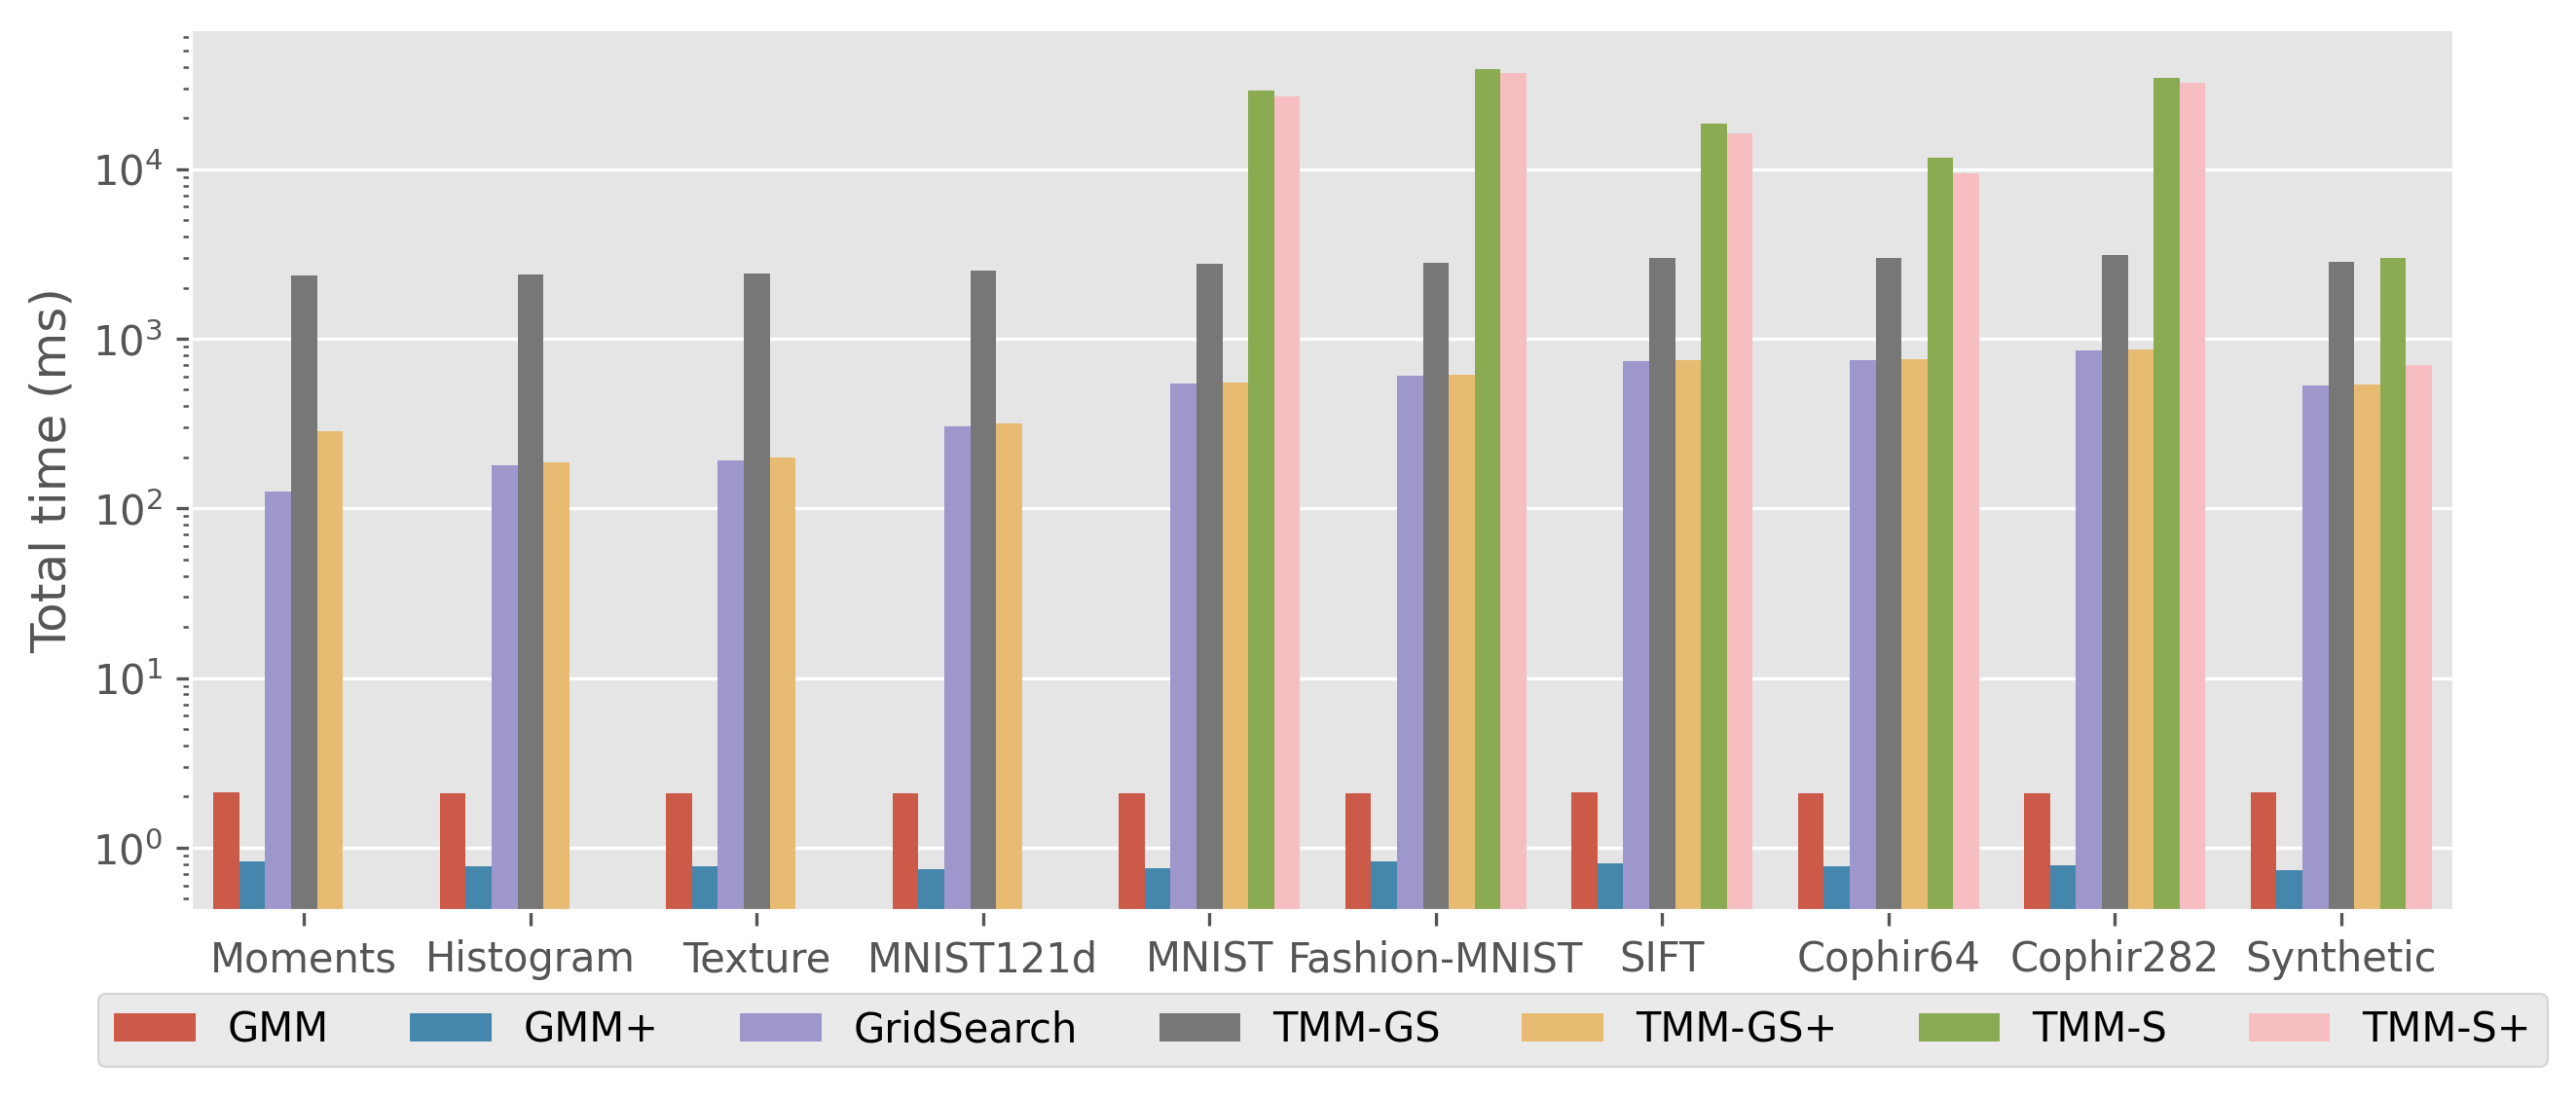

In [28]:
plt.figure(figsize=(10,4), dpi=300)
plt.yscale('log')
sns.barplot(x='base', y='total_time', hue='approach', hue_order=hue_order, data=recommendation_time)
# sns.pointplot(x='base', y='total_time', hue='approach', hue_order=hue_order, data=recommendation_time, scale=1, linestyles='--', markers=["*", "^", "D", ",", ".", "v", "+"])
plt.xlabel('')
plt.ylabel('Total time (ms)')
plt.legend(loc='lower center', ncol=7, bbox_to_anchor=(0.5, -.2))
plt.savefig('/home/seidi/Repositories/seidi_pgac_journal/figures/results_section/results/recommendation_time.pdf', bbox_inches = 'tight', dpi=100)

In [ ]:
recommendation_time[recommendation_time.approach.isin(['TMM-S', 'TMM-S+'])]